# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* Offers sent during 30-day test period (10 offers x 6 fields)
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum money required spend to complete an offer
* reward (int) - reward given for completing an offer (money awarded for the amount spent)
* duration (int) - time for offer to be open, in days
* channels (list of strings) (web, email, mobile, social)

**profile.json**
* Rewards program users (17000 users x 5 fields)
* age (int) - age of the customer (missing value encoded as 118)
* became_member_on (int) - date when customer created an app account (format YYYYMMDD)
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* Event log (306648 events x 4 fields)
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record
* offer id: (string/hash) not associated with any "transaction"
* amount: (numeric) money spent in "transaction"
* reward: (numeric) money gained from "offer completed"


**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [416]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier


%matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)                            

# Exploratory Data Analysis

## Transcript Datatframe

In [326]:
print(transcript.head())   
print(transcript.shape)
print(transcript.info())

                             person           event  \
0  78afa995795e4d85b5d9ceeca43f5fef  offer received   
1  a03223e636434f42ac4c3df47e8bac43  offer received   
2  e2127556f4f64592b11af22de27a7932  offer received   
3  8ec6ce2a7e7949b1bf142def7d0e0586  offer received   
4  68617ca6246f4fbc85e91a2a49552598  offer received   

                                              value  time  
0  {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}     0  
1  {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}     0  
2  {'offer id': '2906b810c7d4411798c6938adc9daaa5'}     0  
3  {'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}     0  
4  {'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}     0  
(306534, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3

The `transcript` DataFrame contains 306,534 entries and four columns: `person`, `event`, `value`, and `time`. Each entry records an interaction, with `person` as the customer ID, `event` describing the type of interaction (e.g., offer received), `value` providing additional details as a dictionary, and `time` indicating the hours since the start of the test. The data types are primarily objects, with `time` as an integer, and there are no missing values in this dataset. The `head` output shows examples where customers received offers, with the specific offer ID stored in the `value` column.

event
transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: count, dtype: int64


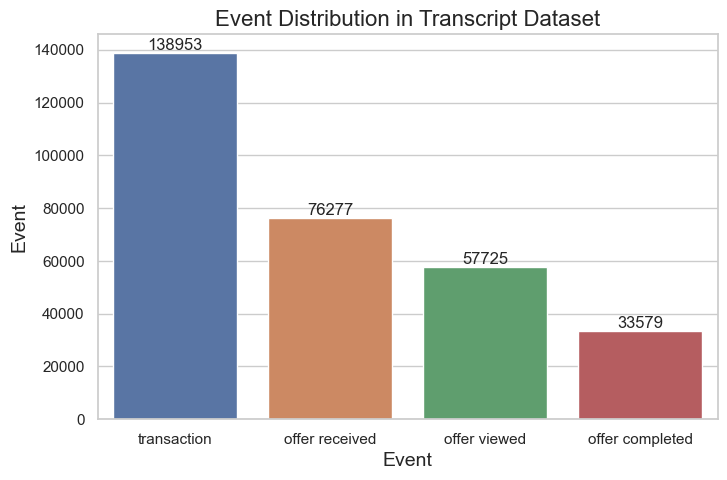

In [327]:
# Examining the distributions of 'events'
event_counts = transcript['event'].value_counts()
print(event_counts)

# Bar plot of 'event'  in the 'transcript' dataset
sns.set(style = 'whitegrid')

# Create a bar plot 
plt.figure(figsize= (8,5))
ax = sns.barplot(x = event_counts.index, y = event_counts.values, hue = event_counts.index)

# Titles and labels
plt.title('Event Distribution in Transcript Dataset', fontsize = 16)
plt.xlabel('Event', fontsize = 14)
plt.ylabel('Event', fontsize =14)

for i in ax.containers:
    ax.bar_label(i,)

plt.show()

The `transcript` dataset shows that **transactions** are the most common event type, with 138,953 occurrences, indicating frequent customer purchases or interactions involving money. **Offer received** events follow at 76,277, suggesting substantial distribution of promotional offers to customers. **Offer viewed** and **offer completed** events are less frequent, with 57,725 and 33,579 occurrences respectively, highlighting that fewer customers actually engage with or complete the offers after receiving them. This distribution suggests a potential gap between receiving offers and acting on them, which could be explored further to optimize offer effectiveness.

count    306534.000000
mean        366.382940
std         200.326314
min           0.000000
25%         186.000000
50%         408.000000
75%         528.000000
max         714.000000
Name: time, dtype: float64


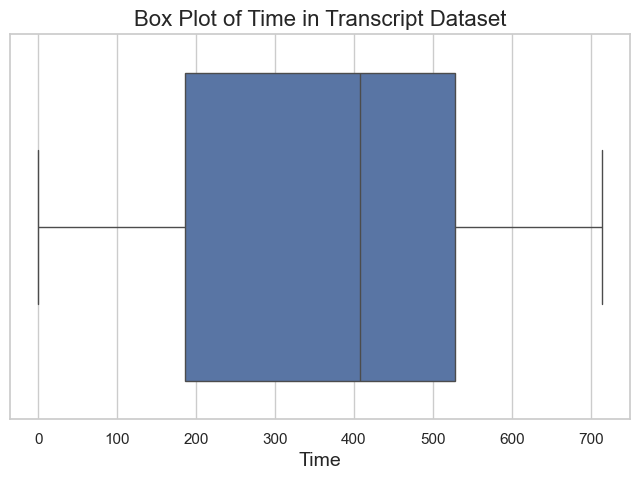

In [328]:
# Examining the 'time'
print(transcript['time'].describe())

# Box Plot of  'age' column

# Set the aesthetic style
sns.set(style='whitegrid')

# Create a box plot for 'age'
plt.figure(figsize = (8, 5))
sns.boxplot(x = transcript['time'])

# Titles and labels
plt.title('Box Plot of Time in Transcript Dataset', fontsize=16)
plt.xlabel('Time', fontsize = 14)

# Show the plot
plt.show()

The `time` column in the `transcript` dataset has a mean of 366 hours and a standard deviation of 200 hours, with values ranging from 0 to 714 hours. The box plot shows the spread of time values, with the median at 408 hours and the interquartile range (IQR) between approximately 186 and 528 hours. There are no extreme outliers, and the data is fairly evenly distributed over the 714-hour range, indicating that events were logged consistently throughout the test period.

In [329]:
# Examining the 'value' column
val_count = transcript['value'].value_counts()
print(val_count)

value
{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'}    14983
{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}    14924
{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}    14891
{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}    14835
{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'}    14374
                                                    ...  
{'amount': 42.31}                                       1
{'amount': 44.62}                                       1
{'amount': 42.27}                                       1
{'amount': 108.89}                                      1
{'amount': 476.33}                                      1
Name: count, Length: 5121, dtype: int64


C:\Users\cerde\AppData\Local\Temp\ipykernel_28300\675717884.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Event', fontsize=12)


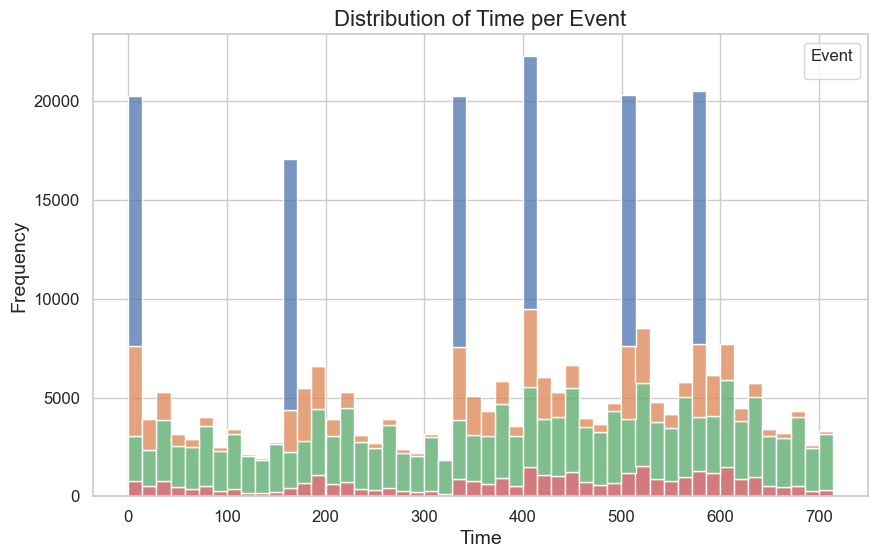

In [330]:
# Histogram for each event type and time

# Set style for seaborn plots
sns.set(style="whitegrid")

# Plot histogram for each event type
plt.figure(figsize=(10, 6))
sns.histplot(data=transcript, x='time', hue='event', multiple='stack', bins=50, legend = True)
plt.title('Distribution of Time per Event', fontsize=16)
plt.xlabel('Time', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='Event', fontsize=12)
plt.show()


The histogram displays the distribution of various events over time within the `transcript` dataset. Peaks in "offer received" events, represented by blue bars, occur at regular intervals, indicating scheduled offer distributions. "Transactions" (green) and "offer viewed" (orange) events are spread more consistently across the timeline, suggesting continuous customer engagement. "Offer completed" events (red) have relatively lower frequency, underscoring that not all received offers lead to completion. This distribution highlights potential cycles in offer distribution and customer response behavior over the test period.

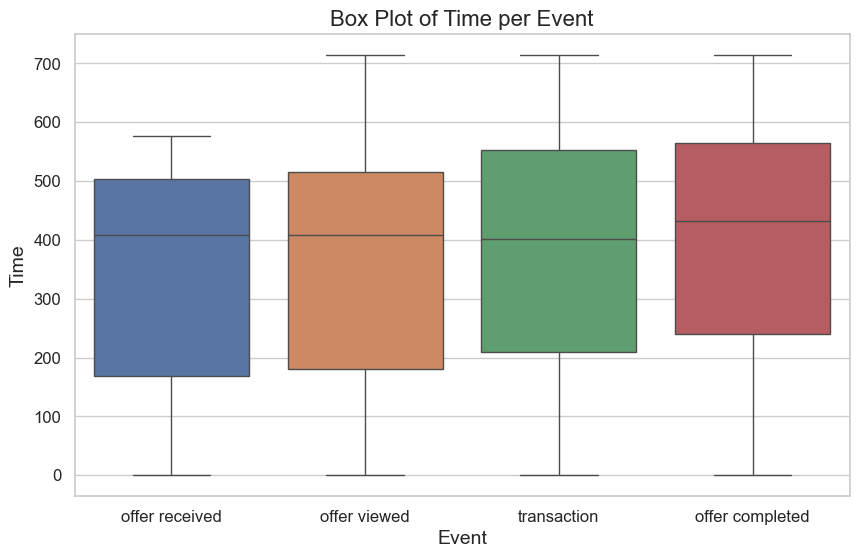

In [331]:
# Box plot for time distribution per event
plt.figure(figsize=(10, 6))
sns.boxplot(data=transcript, x='event', y='time', hue = 'event')

# Add titles and labels
plt.title('Box Plot of Time per Event', fontsize=16)
plt.xlabel('Event', fontsize=14)
plt.ylabel('Time', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()


## Portfolio Dataframe

In [332]:
print(portfolio.head(10))
print(portfolio.shape)

   reward                      channels  difficulty  duration     offer_type  \
0      10       [email, mobile, social]          10         7           bogo   
1      10  [web, email, mobile, social]          10         5           bogo   
2       0          [web, email, mobile]           0         4  informational   
3       5          [web, email, mobile]           5         7           bogo   
4       5                  [web, email]          20        10       discount   
5       3  [web, email, mobile, social]           7         7       discount   
6       2  [web, email, mobile, social]          10        10       discount   
7       0       [email, mobile, social]           0         3  informational   
8       5  [web, email, mobile, social]           5         5           bogo   
9       2          [web, email, mobile]          10         7       discount   

                                 id  
0  ae264e3637204a6fb9bb56bc8210ddfd  
1  4d5c57ea9a6940dd891ad53e9dbe8da0  
2  3f

The `portfolio` dataset contains 10 unique offers, each with details on the reward amount, distribution channels, difficulty level, duration, offer type, and an identifier. Offers vary in reward (e.g., 10, 5, 2), difficulty (e.g., 10, 5, 0), and duration (e.g., 7, 10, 4 days), which influences how accessible and appealing each offer might be to customers. Channels such as "email," "mobile," "social," and "web" indicate the mediums through which offers are distributed, while offer types include "bogo" (buy one, get one), "discount," and "informational," each likely serving different promotional goals. This dataset will be essential in analyzing customer engagement with various offer structures.

In [333]:
print(portfolio.describe())

          reward  difficulty   duration
count  10.000000   10.000000  10.000000
mean    4.200000    7.700000   6.500000
std     3.583915    5.831905   2.321398
min     0.000000    0.000000   3.000000
25%     2.000000    5.000000   5.000000
50%     4.000000    8.500000   7.000000
75%     5.000000   10.000000   7.000000
max    10.000000   20.000000  10.000000


The `portfolio.describe()` output provides a statistical summary of the numerical columns in the `portfolio` dataset. The reward values range from 0 to 10, with a mean of 4.2, suggesting a moderate reward level across offers. Difficulty levels vary widely, from 0 to 20, with an average of 7.7, indicating different thresholds customers must meet to complete offers. Duration spans from 3 to 10 days, with a mean of 6.5, showing a mix of short and longer-term offers. This variability in rewards, difficulty, and duration reflects diverse promotional strategies likely tailored to engage different customer segments.

## Profile Dataset

In [334]:
print(profile.head())

  gender  age                                id  became_member_on    income
0   None  118  68be06ca386d4c31939f3a4f0e3dd783          20170212       NaN
1      F   55  0610b486422d4921ae7d2bf64640c50b          20170715  112000.0
2   None  118  38fe809add3b4fcf9315a9694bb96ff5          20180712       NaN
3      F   75  78afa995795e4d85b5d9ceeca43f5fef          20170509  100000.0
4   None  118  a03223e636434f42ac4c3df47e8bac43          20170804       NaN


The `profile` dataset contains customer information, with fields for gender, age, id, became_member_on (membership start date), and income. Missing values are present in `gender` (represented as `None`) and `income`, and certain ages are marked as 118, possibly indicating missing or anonymized data. The `became_member_on` column shows the date each customer joined, formatted as `YYYYMMDD`. This dataset provides demographic insights that can be used to analyze customer behavior and tailor marketing strategies based on attributes like age, gender, and income.

In [335]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


The `profile.info()` output reveals that the `profile` dataset consists of 17,000 entries across five columns: `gender`, `age`, `id`, `became_member_on`, and `income`. The gender and income columns have missing values, with 14,825 non-null entries each. The id and became_member_on columns are fully populated, while age is complete but may contain placeholder values (e.g., 118 for missing data). This summary provides an overview of the data's completeness and types, which is helpful for determining appropriate preprocessing steps before analysis.

In [336]:
# Get the number of null values in 'profile' dataset
print(profile.isnull().sum())

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64


The output shows the count of missing values in each column of the `profile` dataset. The gender and income columns have 2,175 missing values each, while age, id, and became_member_on are fully populated. This confirms that missing data is limited to specific demographic attributes, which will require imputation or other handling methods to ensure data quality for analysis.

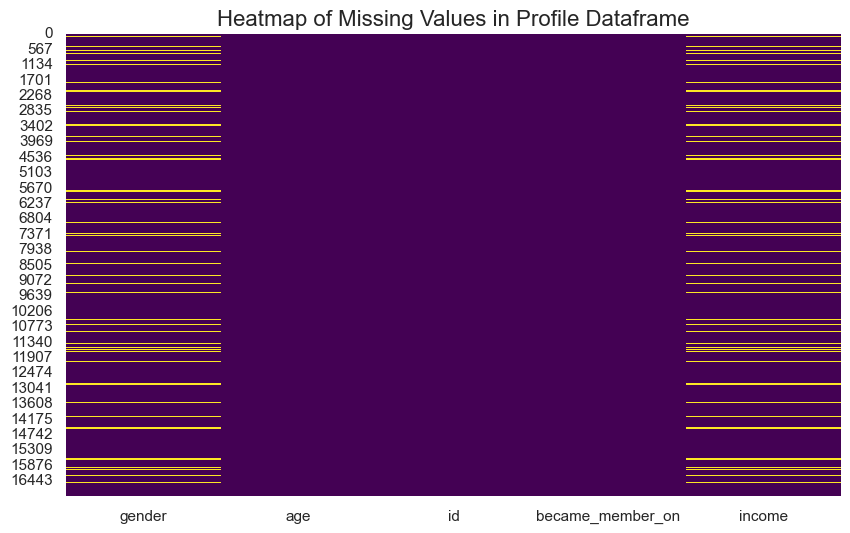

In [337]:
# Create a heatmap to visualize missing values
plt.figure(figsize=(10, 6))
sns.heatmap(profile.isnull(), cbar=False, cmap='viridis')

# Add a title
plt.title('Heatmap of Missing Values in Profile Dataframe', fontsize=16)

# Show the plot
plt.show()


The heatmap visualizes missing values in the `profile` dataset, with yellow lines indicating rows with null entries. Only the gender and income columns have missing values, as seen by the vertical yellow streaks, while age, id, and became_member_on are fully populated. This pattern suggests consistent missing data across these two demographic columns, highlighting areas where imputation or other data-cleaning techniques may be needed to ensure data completeness.

In [338]:
# Count the occurences of each gender
gender_counts = profile['gender'].value_counts()
index = ['Male', 'Female', 'Other']
gender_counts.index = index
print(gender_counts)

Male      8484
Female    6129
Other      212
Name: count, dtype: int64


The gender distribution in the `profile` dataset shows that there are 8,484 entries labeled as Male, 6,129 as Female, and 212 as Other. This count excludes any missing values in the `gender` column, highlighting a slight imbalance favoring male customers. The "Other" category, with fewer entries, might represent customers who prefer not to specify gender or are categorized outside the binary classification, providing an inclusive approach in the dataset.

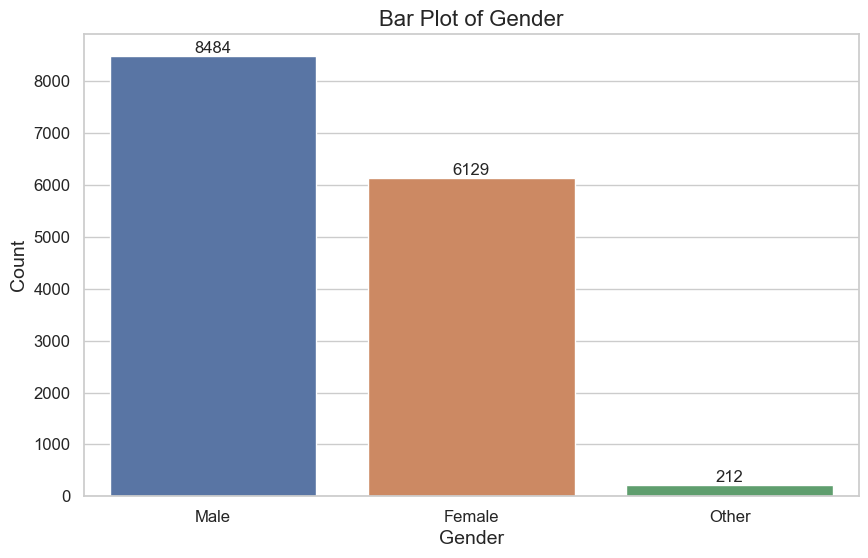

In [339]:
# Bar Plot for 'gender'
plt.figure(figsize = (10, 6))
ax = sns.barplot( x = gender_counts.index, y = gender_counts.values, hue = gender_counts.index)

# Add titles and labels
plt.title('Bar Plot of Gender', fontsize=16)
plt.xlabel('Gender', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add the count labels directly on top of the bars
for i in ax.containers:
    ax.bar_label(i,) 


plt.show()

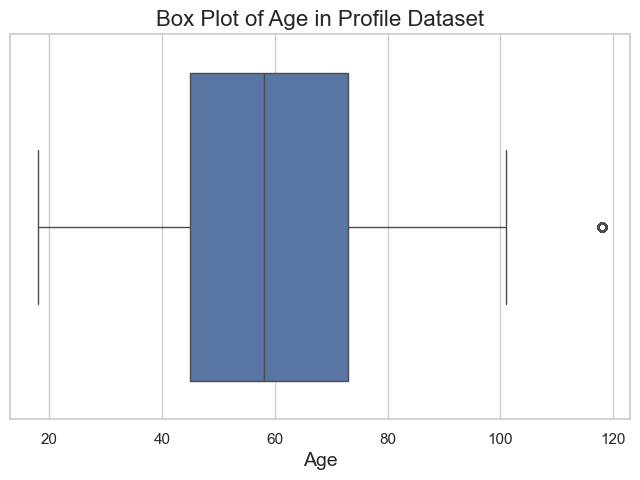

count    17000.000000
mean        62.531412
std         26.738580
min         18.000000
25%         45.000000
50%         58.000000
75%         73.000000
max        118.000000
Name: age, dtype: float64

In [340]:
# Box Plot of  'age' column

# Set the aesthetic style
sns.set(style='whitegrid')

# Create a box plot for 'age'
plt.figure(figsize = (8, 5))
sns.boxplot(x = profile['age'])

# Titles and labels
plt.title('Box Plot of Age in Profile Dataset', fontsize=16)
plt.xlabel('Age', fontsize = 14)

# Show the plot
plt.show()

profile['age'].describe()

The bar plot illustrates the distribution of gender in the `profile` dataset, with Male (8,484) and Female (6,129) representing the majority of entries. The Other category, with only 212 entries, is significantly smaller, indicating less frequent representation in this dataset. This plot visually reinforces the slight gender imbalance favoring males, while also reflecting the inclusive approach to gender categorization by including a non-binary option.

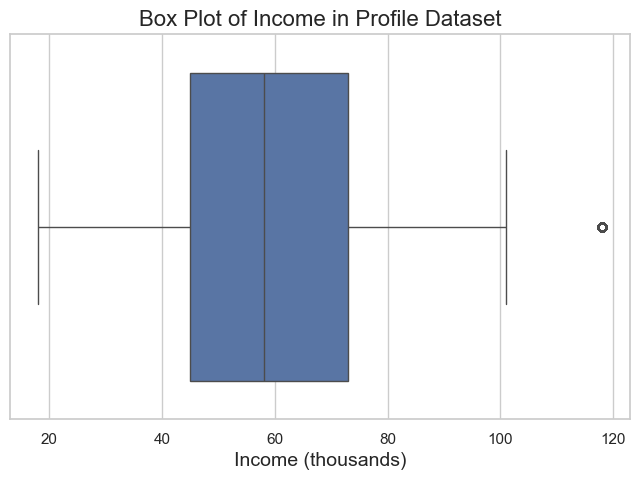

In [341]:
# Box Plot of  'income' column

# Set the aesthetic style
sns.set(style='whitegrid')

# Create a box plot for 'age'
plt.figure(figsize = (8, 5))
sns.boxplot(x = profile['age'])

# Titles and labels
plt.title('Box Plot of Income in Profile Dataset', fontsize=16)
plt.xlabel('Income (thousands)', fontsize = 14)

# Show the plot
plt.show()


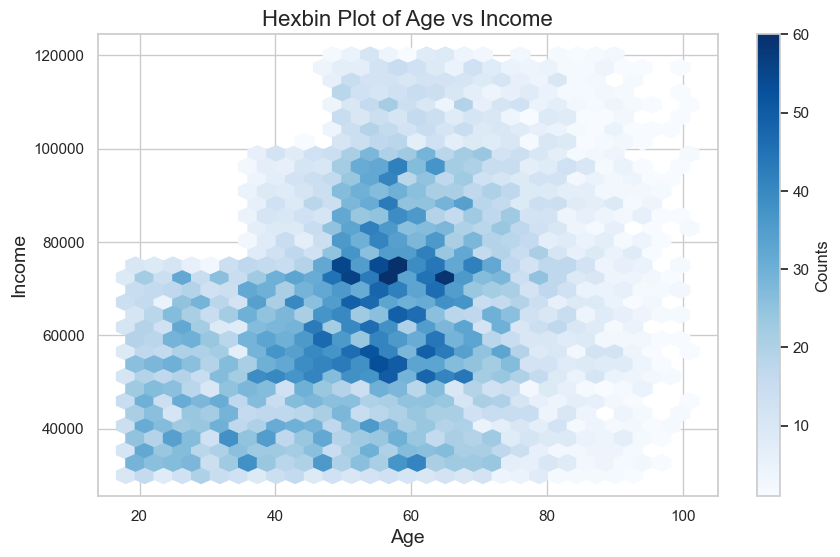

In [342]:
# Scatter plot: Relationship between Age and Income

plt.figure(figsize=(10, 6))

# Create the hexbin plot
plt.hexbin(profile['age'], profile['income'], gridsize=30, cmap='Blues', mincnt=1)

# Add titles and labels
plt.title('Hexbin Plot of Age vs Income', fontsize=16)
plt.xlabel('Age', fontsize=14)
plt.ylabel('Income', fontsize=14)

# Add color bar to show density scale
plt.colorbar(label='Counts')

plt.show()



The box plot of Income in the `profile` dataset shows that the middle 50% of incomes (the interquartile range) lies between approximately $50,000 and $75,000. The median income is centered near $60,000, while the range extends from around $30,000 to $120,000. There is a potential outlier on the higher end, but overall, the income distribution appears moderately symmetric, providing a snapshot of the customer base's economic diversity.

C:\Users\cerde\AppData\Local\Temp\ipykernel_28300\136840926.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x=profile['age_cat'], y=profile['income'], palette='muted')


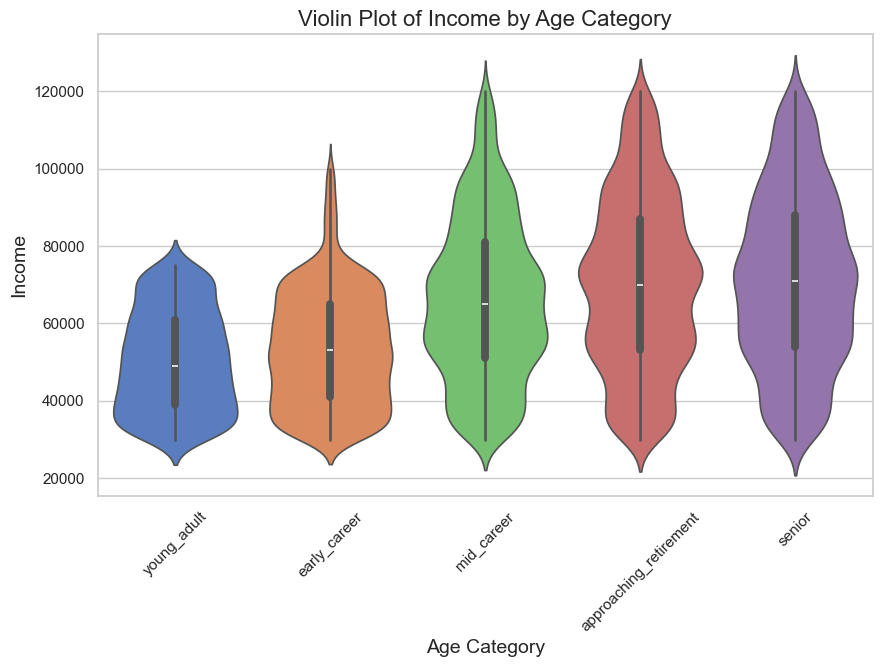

In [343]:
# Violin graphs

# Define the age bins and corresponding labels
bins = [17, 25, 40, 55, 70, float('inf')]
labels = ['young_adult', 'early_career', 'mid_career', 'approaching_retirement', 'senior']

# Create the 'age_cat' column using pd.cut
profile['age_cat'] = pd.cut(profile['age'], bins=bins, labels=labels, right=True)

plt.figure(figsize=(10, 6))

# Create the violin plot
sns.violinplot(x=profile['age_cat'], y=profile['income'], palette='muted')

# Add titles and labels
plt.title('Violin Plot of Income by Age Category', fontsize=16)
plt.xlabel('Age Category', fontsize=14)
plt.ylabel('Income', fontsize=14)

plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()


The violin plot displays the distribution of income across different age categories in the `profile` dataset. Each age category (e.g., "young adult," "early career," "mid-career") has a unique income spread, with median values marked by white dots within each violin. While income generally increases with age, the "mid-career" group shows the widest income range, and "senior" and "approaching retirement" categories exhibit more even distributions. This visualization highlights how income varies with age, potentially guiding targeted marketing based on demographic financial capacity.

# Preprocessing & Feauture Engineering

## Transcript dataset

In [344]:
print(transcript.head())

                             person           event  \
0  78afa995795e4d85b5d9ceeca43f5fef  offer received   
1  a03223e636434f42ac4c3df47e8bac43  offer received   
2  e2127556f4f64592b11af22de27a7932  offer received   
3  8ec6ce2a7e7949b1bf142def7d0e0586  offer received   
4  68617ca6246f4fbc85e91a2a49552598  offer received   

                                              value  time  
0  {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}     0  
1  {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}     0  
2  {'offer id': '2906b810c7d4411798c6938adc9daaa5'}     0  
3  {'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}     0  
4  {'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}     0  


In [345]:
# Create an offer_id column
def extract_offer_id(column):
    # Check if column is a dictionary and contains the relevant keys
    if isinstance(column, dict):
        # Handle case with 'offer id' (with a space)
        if 'offer id' in column:
            return column.get('offer id', np.nan)
        # Handle case with 'offer_id' (with an underscore)
        elif 'offer_id' in column:
            return column.get('offer_id', np.nan)
    # Return NaN if none of the conditions are met (e.g., for transaction events)
    return np.nan


In [346]:
transcript['offer_id'] = transcript['value'].apply(extract_offer_id)

print(transcript['offer_id'].head())
print(transcript['offer_id'].value_counts())
print(transcript['offer_id'].isnull().sum())

0    9b98b8c7a33c4b65b9aebfe6a799e6d9
1    0b1e1539f2cc45b7b9fa7c272da2e1d7
2    2906b810c7d4411798c6938adc9daaa5
3    fafdcd668e3743c1bb461111dcafc2a4
4    4d5c57ea9a6940dd891ad53e9dbe8da0
Name: offer_id, dtype: object
offer_id
fafdcd668e3743c1bb461111dcafc2a4    20241
2298d6c36e964ae4a3e7e9706d1fb8c2    20139
f19421c1d4aa40978ebb69ca19b0e20d    19131
4d5c57ea9a6940dd891ad53e9dbe8da0    18222
ae264e3637204a6fb9bb56bc8210ddfd    18062
9b98b8c7a33c4b65b9aebfe6a799e6d9    16202
2906b810c7d4411798c6938adc9daaa5    15767
5a8bc65990b245e5a138643cd4eb9837    14305
0b1e1539f2cc45b7b9fa7c272da2e1d7    13751
3f207df678b143eea3cee63160fa8bed    11761
Name: count, dtype: int64
138953


The function `extract_offer_id` is used to extract the `offer_id` from the `value` column in the `transcript` dataset. It checks if each entry in `value` is a dictionary and then looks for keys like `'offer id'`, `'offer_id'`, or `'offer-id'` to handle potential variations. This new `offer_id` column enables tracking of specific offers across events. The output shows the `offer_id` values along with their counts, revealing that the most frequent offers have over 20,000 occurrences, which helps in understanding the popularity and reach of different offers. There are 138,953 entries with valid `offer_id`s, indicating non-transaction events associated with offers.

In [347]:
# Create an 'amount' column

def extract_amount(column):
        # Check if column is a dictionary and contains the relevant keys
    if isinstance(column, dict):
        # Handle case with 'offer id' (with a space)
        if 'amount' in column:
            return column.get('amount', np.nan)
    # Return NaN if the condition is not met
    return np.nan

transcript['amount'] = transcript['value'].apply(extract_amount)

print(transcript['amount'].head())
print(transcript['amount'].value_counts())
print(transcript['amount'].isnull().sum())

0   NaN
1   NaN
2   NaN
3   NaN
4   NaN
Name: amount, dtype: float64
amount
0.05      431
0.66      166
1.18      165
1.01      163
1.23      161
         ... 
42.31       1
44.62       1
42.27       1
108.89      1
476.33      1
Name: count, Length: 5103, dtype: int64
167581


The `extract_amount` function creates a new `amount` column in the `transcript` dataset by extracting the transaction amount from the `value` dictionary. This function checks if `value` contains the key `'amount'` and retrieves its value; otherwise, it returns `NaN`. The output shows that there are 167,581 missing values (NaN), which likely correspond to non-transaction events. The dataset also includes various transaction amounts, with the most common being 0.05, recorded 431 times. This column will be useful in analyzing the monetary aspect of customer transactions.

In [348]:
# Create a 'reward' column

def extract_reward(column):
        # Check if column is a dictionary and contains the relevant keys
    if isinstance(column, dict):
        # Handle case with 'offer id' (with a space)
        if 'reward' in column:
            return column.get('reward', np.nan)
    # Return NaN if the condition is not met
    return np.nan

transcript['reward'] = transcript['value'].apply(extract_reward)

print(transcript['reward'].head())
print(transcript['reward'].value_counts())
print(transcript['reward'].isnull().sum())

0   NaN
1   NaN
2   NaN
3   NaN
4   NaN
Name: reward, dtype: float64
reward
5.0     12070
2.0      9334
10.0     7019
3.0      5156
Name: count, dtype: int64
272955


The `extract_reward` function creates a new `reward` column by extracting reward values from the `value` column in the `transcript` dataset. It checks if the entry in `value` contains the key `'reward'` and retrieves its value; otherwise, it assigns `NaN`. The output reveals that there are 272,955 missing values (likely for non-reward-related events). The most common reward amounts are 5.0, 2.0, and 10.0, which appear with decreasing frequency. This column will help in analyzing customer responses to different reward amounts and understanding the distribution of earned rewards.

## Merging dataframes

In [349]:
# Merge transcript with profile on the 'person' and 'id' columns
merged_df = pd.merge(transcript, profile, how='left', left_on='person', right_on='id')

# Merge the merged_df with portfolio on 'offer_id'
final_merged_df = pd.merge(merged_df, portfolio, how='left', left_on='offer_id', right_on='id')

# Display the first few rows to check the result
print(final_merged_df.columns)
print(final_merged_df.shape)
print(final_merged_df.head())

Index(['person', 'event', 'value', 'time', 'offer_id', 'amount', 'reward_x',
       'gender', 'age', 'id_x', 'became_member_on', 'income', 'age_cat',
       'reward_y', 'channels', 'difficulty', 'duration', 'offer_type', 'id_y'],
      dtype='object')
(306534, 19)
                             person           event  \
0  78afa995795e4d85b5d9ceeca43f5fef  offer received   
1  a03223e636434f42ac4c3df47e8bac43  offer received   
2  e2127556f4f64592b11af22de27a7932  offer received   
3  8ec6ce2a7e7949b1bf142def7d0e0586  offer received   
4  68617ca6246f4fbc85e91a2a49552598  offer received   

                                              value  time  \
0  {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}     0   
1  {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}     0   
2  {'offer id': '2906b810c7d4411798c6938adc9daaa5'}     0   
3  {'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}     0   
4  {'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}     0   

                           offer_id  

The `merged_df` and `final_merged_df` dataframes combine information from the `transcript`, `profile`, and `portfolio` datasets. The initial merge connects `transcript` with `profile` based on the `person` and `id` columns, adding demographic information like `age`, `gender`, and `income` to each event. The second merge incorporates `portfolio` data using `offer_id`, bringing in offer-specific details such as `reward`, `duration`, and `offer_type`. The final dataframe, `final_merged_df`, consists of 306,534 entries and 19 columns, allowing for comprehensive analysis of customer interactions, demographics, and offer characteristics. This consolidated view facilitates in-depth exploration of how different customer segments respond to various offers.

### Rename the merged dataset

In [350]:
df = final_merged_df

The code simply renames the final merged dataset `final_merged_df` to `df` for ease of reference and simplicity in subsequent analysis. This allows for more concise and readable code as the merged dataset will now be accessed with the variable `df`.

### Clean and Organize Merged Dataframe

After merging the dataframes, we need to clean and arrange the resulting dataset for better analysis. This step involves removing duplicate columns that were generated during the merge and dropping unnecessary columns that were used to create new, more meaningful ones. Additionally, renaming certain columns ensures clarity and consistency throughout the dataset. By cleaning and organizing the dataframe in this way, we enhance the readability and efficiency of the data, making it easier to perform further analyses.

In [351]:
print(df.columns)

# Drop the repeating columns
df = df.drop(['value', 'id_x', 'id_y'], axis =1)

# Rename the columns according to their meaning
df.rename(columns = {'reward_x': 'reward_earned', 'reward_y':'reward_offer'}, inplace = True)

print(df.columns)

Index(['person', 'event', 'value', 'time', 'offer_id', 'amount', 'reward_x',
       'gender', 'age', 'id_x', 'became_member_on', 'income', 'age_cat',
       'reward_y', 'channels', 'difficulty', 'duration', 'offer_type', 'id_y'],
      dtype='object')
Index(['person', 'event', 'time', 'offer_id', 'amount', 'reward_earned',
       'gender', 'age', 'became_member_on', 'income', 'age_cat',
       'reward_offer', 'channels', 'difficulty', 'duration', 'offer_type'],
      dtype='object')


The code cleans and organizes the merged dataframe by removing redundant columns (`'value'`, `'id_x'`, `'id_y'`) that were generated during the merging process and are no longer necessary. It then renames columns for clarity: `'reward_x'` is renamed to `'reward_earned'`, and `'reward_y'` to `'reward_offer'`, making their meanings more explicit. This step improves the dataset’s readability and makes the column names more intuitive, streamlining further analysis.

In [352]:
# Replace the placeholder value '118' in the 'age' column with 'np.nan' to mark these entries as missing values (NaN). 

df['age'] = df['age'].replace(118, np.nan)


This code replaces placeholder values of `118` in the `'age'` column with `np.nan`, marking them as missing values. This step is essential for accurate data analysis, as `118` was likely used to represent unknown ages. Converting these values to `NaN` enables more reliable handling of missing data, allowing for appropriate imputation or exclusion in subsequent steps.

In [353]:
# Create a new column 'no_channels' indicating the number of channels

# Replace NaN values in 'channels' with an empty list
df['channels'] = df['channels'].apply(lambda x: x if isinstance(x, list) else [])

# Create a new column 'no_channels' indicating the number of channels
df['no_channels'] = df['channels'].apply(len)

# Display the first few rows to check the result
print(df.head())      

                             person           event  time  \
0  78afa995795e4d85b5d9ceeca43f5fef  offer received     0   
1  a03223e636434f42ac4c3df47e8bac43  offer received     0   
2  e2127556f4f64592b11af22de27a7932  offer received     0   
3  8ec6ce2a7e7949b1bf142def7d0e0586  offer received     0   
4  68617ca6246f4fbc85e91a2a49552598  offer received     0   

                           offer_id  amount  reward_earned gender   age  \
0  9b98b8c7a33c4b65b9aebfe6a799e6d9     NaN            NaN      F  75.0   
1  0b1e1539f2cc45b7b9fa7c272da2e1d7     NaN            NaN   None   NaN   
2  2906b810c7d4411798c6938adc9daaa5     NaN            NaN      M  68.0   
3  fafdcd668e3743c1bb461111dcafc2a4     NaN            NaN   None   NaN   
4  4d5c57ea9a6940dd891ad53e9dbe8da0     NaN            NaN   None   NaN   

   became_member_on    income                 age_cat  reward_offer  \
0          20170509  100000.0                  senior           5.0   
1          20170804       NaN           

This code creates a new column, `'no_channels'`, which counts the number of communication channels listed for each offer. First, it replaces any `NaN` values in the `'channels'` column with an empty list to avoid errors in counting. Then, by applying `len()` to each entry, it calculates the total channels available per offer. This column provides insight into the reach or flexibility of each offer in terms of available communication channels.

In [354]:
# Convert the date in the became_member_on column to a proper datetime format.
df['became_member_on'] = pd.to_datetime(df['became_member_on'], format='%Y%m%d')

This code converts the `'became_member_on'` column in the dataset to a datetime format using the specified `%Y%m%d` format. This change is essential for performing time-based analyses or aggregations, as it allows the dates to be recognized and manipulated as proper datetime objects rather than strings or integers. By converting it, you gain the flexibility to extract specific components like the year or month, calculate membership duration, or analyze trends over time.

In [355]:
# Create 'membership_duration' column by subtracting the membership start date from the current date.
df['membership_duration'] = (pd.to_datetime('today') - df['became_member_on']).dt.days

This code calculates the duration of each customer's membership by creating a new column, `'membership_duration'`. It subtracts the membership start date (`'became_member_on'`) from the current date (`today`), resulting in the number of days each customer has been a member. This transformation enables time-based insights, such as analyzing customer engagement over the length of their membership or identifying trends among long-term versus newer members.

### Age Categorization

To better analyze the customer data, I categorized the `age` column into distinct life-stage groups. This allows for easier comparison and insights across different age demographics. The categories we defined are:

Young Adult (18-25): Represents individuals in the early stages of adulthood.
Early Career (26-40): Individuals likely in the early stages of their professional careers.
Mid-Career (41-55): People who are typically well-established in their careers.
Approaching Retirement (56-70): Those nearing the retirement age.
Senior (71 and above): Individuals who are generally retired or in the later stages of life.

By creating these age groups, I plan to assess trends and behaviors within these specific demographics, such as offer acceptance rates, purchasing patterns, or responsiveness to promotions.

In [356]:
# Define the age bins and corresponding labels
bins = [17, 25, 40, 55, 70, float('inf')]
labels = ['young_adult', 'early_career', 'mid_career', 'approaching_retirement', 'senior']

# Create the 'age_cat' column using pd.cut
df['age_cat'] = pd.cut(df['age'], bins=bins, labels=labels, right=True)

# Display the first few rows to check the result
print(df[['age', 'age_cat']].head())

    age                 age_cat
0  75.0                  senior
1   NaN                     NaN
2  68.0  approaching_retirement
3   NaN                     NaN
4   NaN                     NaN


This section categorizes customers into life-stage groups based on their age. By defining bins for different stages (e.g., "young adult," "early career," etc.), the `age_cat` column enables targeted analysis across age demographics. This categorization is particularly useful for examining trends in customer behavior, such as responsiveness to offers or purchasing patterns, within distinct age groups. Through these insights, it’s easier to tailor marketing and engagement strategies to specific demographic segments.

In [357]:
print(df.columns)
print(df.info())
print(df.describe())

Index(['person', 'event', 'time', 'offer_id', 'amount', 'reward_earned',
       'gender', 'age', 'became_member_on', 'income', 'age_cat',
       'reward_offer', 'channels', 'difficulty', 'duration', 'offer_type',
       'no_channels', 'membership_duration'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   person               306534 non-null  object        
 1   event                306534 non-null  object        
 2   time                 306534 non-null  int64         
 3   offer_id             167581 non-null  object        
 4   amount               138953 non-null  float64       
 5   reward_earned        33579 non-null   float64       
 6   gender               272762 non-null  object        
 7   age                  272762 non-null  float64       
 8   became_member_on     30

This summary provides an overview of the final merged and cleaned dataset. The `info()` output confirms that the DataFrame consists of 306,534 entries across 18 columns, detailing data types, non-null counts, and memory usage. Key columns like `amount`, `reward_earned`, and `age` have missing values, as indicated by the non-null counts, which may need further handling. The `describe()` output offers statistical insights, such as the mean `membership_duration` (490.8 days), indicating the average time customers have been members, and the `income` mean of approximately 72,777. The presence of categorical and numeric data types enables comprehensive analysis across diverse metrics, enhancing the dataset's usability for further exploratory or predictive tasks.

offer_type
bogo             71617
discount         69898
informational    26066
Name: count, dtype: int64


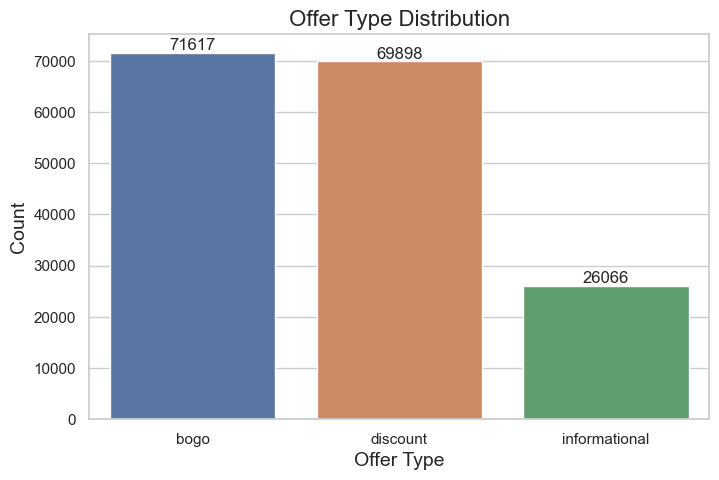

In [358]:
# Examining the distributions of 'offer_type'
offer_type_counts = df['offer_type'].value_counts()
print(offer_type_counts)

# Bar plot of 'offer_type' 
sns.set(style = 'whitegrid')

# Create a bar plot 
plt.figure(figsize= (8,5))
ax = sns.barplot(x = offer_type_counts.index, y = offer_type_counts.values, hue = offer_type_counts.index)

# Titles and labels
plt.title('Offer Type Distribution', fontsize = 16)
plt.xlabel('Offer Type', fontsize = 14)
plt.ylabel('Count', fontsize =14)

for i in ax.containers:
    ax.bar_label(i,)

plt.show()

The bar plot for "Offer Type Distribution" highlights the frequency of different types of offers in the dataset. The "bogo" (buy one, get one) offers are the most frequent, totaling 71,617 occurrences, closely followed by "discount" offers at 69,898. The "informational" type, which likely serves to provide users with details about products without a direct purchase incentive, has a significantly lower count at 26,066. This distribution indicates a heavier emphasis on promotional incentives (bogo and discount) rather than informational offers, suggesting a strategy focused on directly driving consumer engagement through incentives rather than simply raising awareness.

age_cat
young_adult               19822
early_career              45291
senior                    47023
mid_career                76032
approaching_retirement    84594
Name: count, dtype: int64


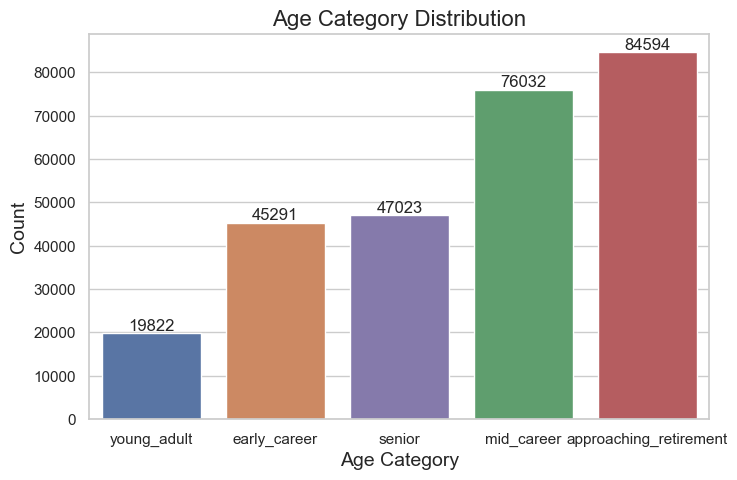

In [359]:
# Examining the distributions of 'age_cat'
age_cat_counts = df['age_cat'].value_counts().sort_values(ascending = True)
print(age_cat_counts)

# Bar plot of 'age_cat' 
sns.set(style = 'whitegrid')

# Create a bar plot 
plt.figure(figsize= (8,5))
ax = sns.barplot(x = age_cat_counts.index, y = age_cat_counts.values, hue = age_cat_counts.index, order=age_cat_counts.index)

# Titles and labels
plt.title('Age Category Distribution', fontsize = 16)
plt.xlabel('Age Category', fontsize = 14)
plt.ylabel('Count', fontsize =14)

for i in ax.containers:
    ax.bar_label(i,)

plt.show()

The bar plot of age category distribution provides a clear overview of the customer segmentation by life stage. The category with the highest count is "approaching retirement," comprising 84,594 entries, followed by "mid-career" with 76,032 entries. This suggests a strong presence of customers in more established career phases. The "young adult" category, however, has the lowest representation, with only 19,822 entries, indicating fewer individuals in the early stages of adulthood within the customer base. These age demographics may reflect the target audience of the offers and inform tailored engagement strategies for different age groups.

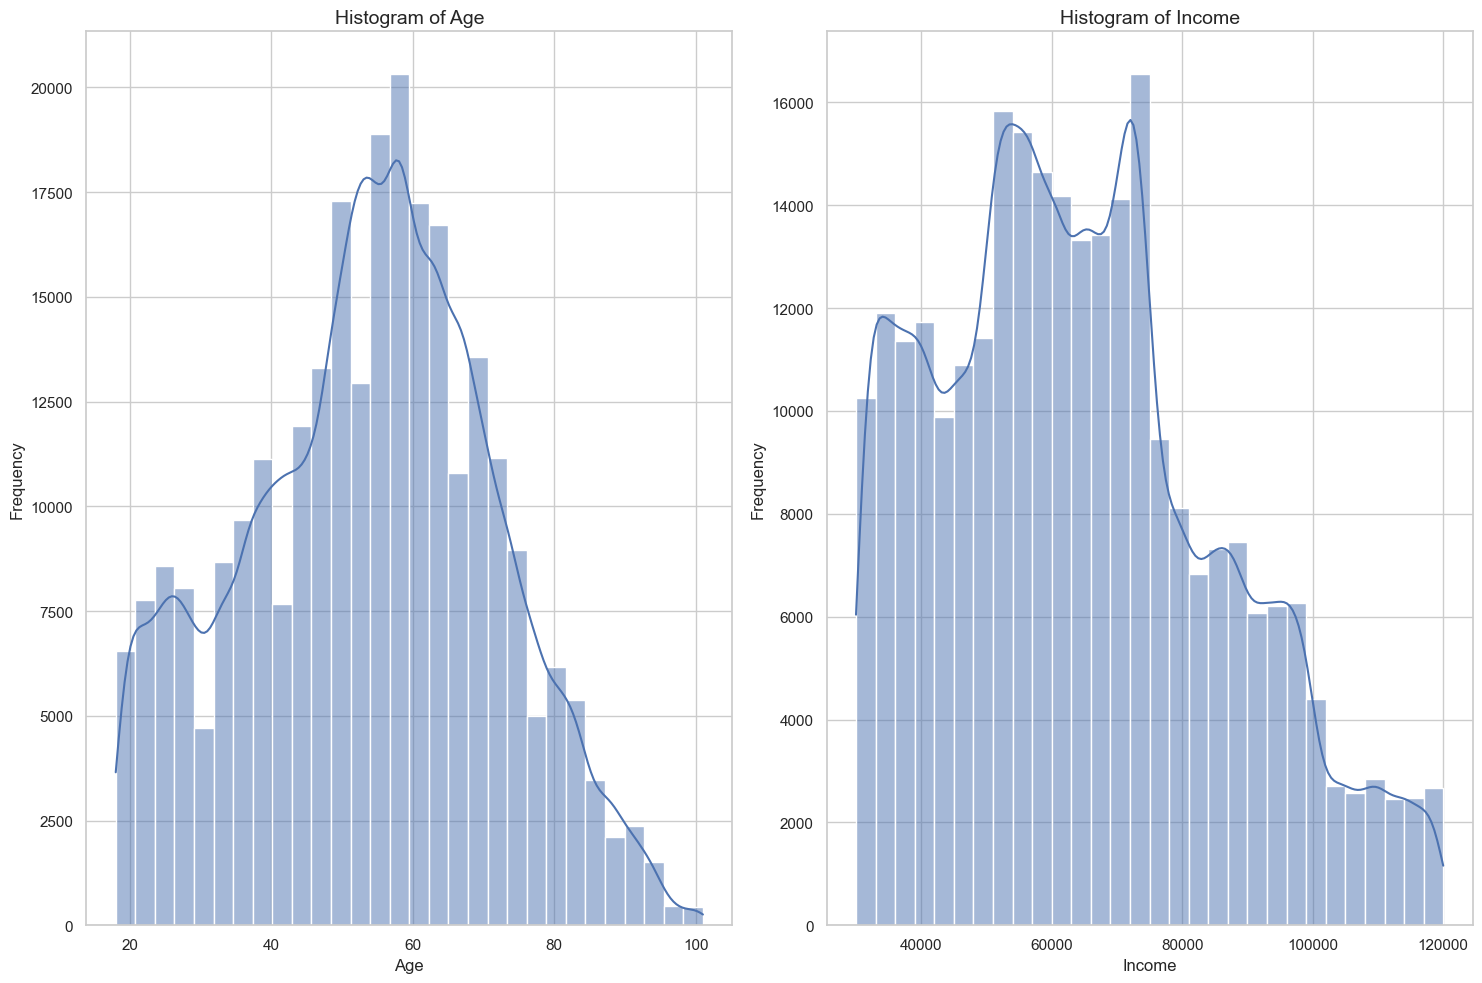

In [360]:
# Examining the distributions of 'age' and 'income'
sns.set(style="whitegrid")
plt.figure(figsize=(15, 10))

# List of numeric columns to plot
numeric_columns = ['age', 'income']

# Loop through each column and plot a histogram
for i, column in enumerate(numeric_columns, 1):
    plt.subplot(1, 2, i)  # Adjust the grid layout (1 rows, 2 columns)
    sns.histplot(df[column].dropna(), bins=30, kde=True)  # Drop missing values and add KDE
    plt.title(f'Histogram of {column.capitalize()}', fontsize=14)
    plt.xlabel(column.capitalize(), fontsize=12)
    plt.ylabel('Frequency', fontsize=12)

plt.tight_layout()  # Adjust spacing to fit all plots nicely
plt.show()


The histograms of age and income provide a clear view of their distributions across the dataset. The age distribution shows a peak in the mid-adult range, tapering off at higher ages, while income displays a bell-shaped distribution with a concentration around the median income range. These visualizations offer insight into the demographic spread, helping to identify key segments for targeted analysis.

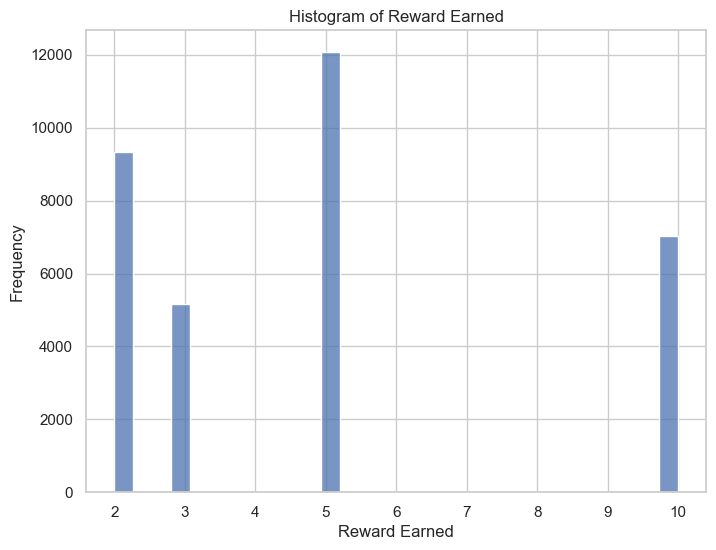

In [361]:
# Plotting histogram for 'reward_earned'
plt.figure(figsize=(8, 6))
sns.histplot(df['reward_earned'].dropna(), bins=30)
plt.title("Histogram of Reward Earned")
plt.xlabel("Reward Earned")
plt.ylabel("Frequency")
plt.show()




The histogram of "Reward Earned" reveals that most rewards earned fall into specific values, particularly around 2, 3, 5, and 10. This clustered distribution suggests a few dominant reward values, potentially reflecting common reward structures or thresholds in the dataset.

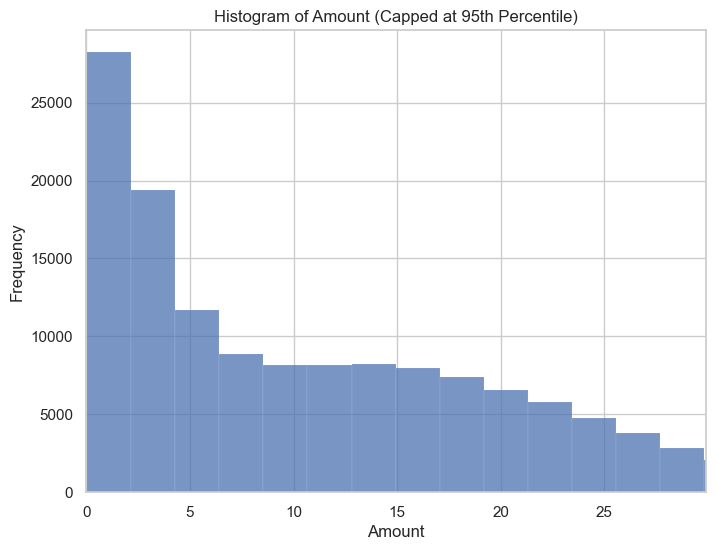

In [362]:

# Calculate the 95th percentile of the 'amount' column to set as the upper limit
upper_limit = df['amount'].quantile(0.95)

# Plotting histogram for 'amount' with capped x-axis
plt.figure(figsize=(8, 6))
sns.histplot(df['amount'].dropna(), bins=500)
plt.title("Histogram of Amount (Capped at 95th Percentile)")
plt.xlabel("Amount")
plt.ylabel("Frequency")
plt.xlim(0, upper_limit)  # Set x-axis limit to the 95th percentile

plt.show()


The histogram of "Amount," capped at the 95th percentile, indicates that the majority of transaction amounts are concentrated at lower values, with a sharp decline in frequency as the amount increases. This skewed distribution suggests that smaller transaction amounts are far more common, while larger transactions are relatively rare in this dataset.

In [363]:
df['amount'].describe()

count    138953.000000
mean         12.777356
std          30.250529
min           0.050000
25%           2.780000
50%           8.890000
75%          18.070000
max        1062.280000
Name: amount, dtype: float64

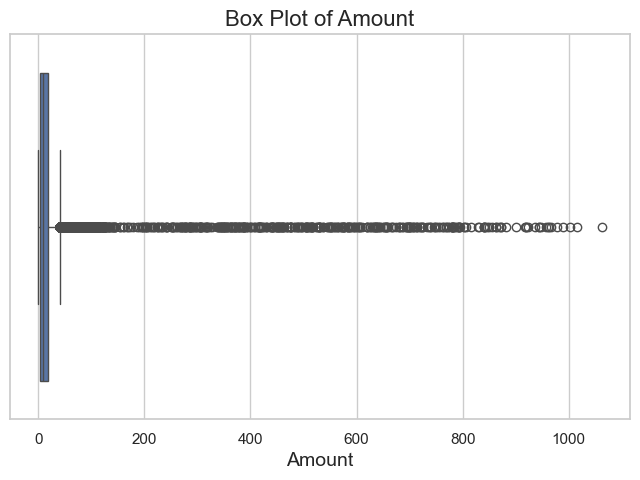

In [364]:
# Box Plot of  'amount' column

# Set the aesthetic style
sns.set(style='whitegrid')

# Create a box plot for 'age'
plt.figure(figsize = (8, 5))
sns.boxplot(x = df['amount'])

# Titles and labels
plt.title('Box Plot of Amount', fontsize=16)
plt.xlabel('Amount', fontsize = 14)

# Show the plot
plt.show()


The descriptive statistics for the "Amount" column reveal a mean transaction amount of approximately 12.78, with a standard deviation of 30.25, indicating significant variability. The data is highly skewed, as evidenced by the 75th percentile at 18.07 and a maximum value reaching 1062.28. This suggests that while most transactions are of smaller amounts, a few large transactions push the maximum value considerably higher.

### Winsorizing to reduce in the 'amount' column

In [365]:
# Calculate the 95th percentile of 'amount' to set as the upper x-limit
upper_limit = df['amount'].quantile(0.95)

df['amount'] = df['amount'].apply(lambda x: upper_limit if x>=upper_limit else x)


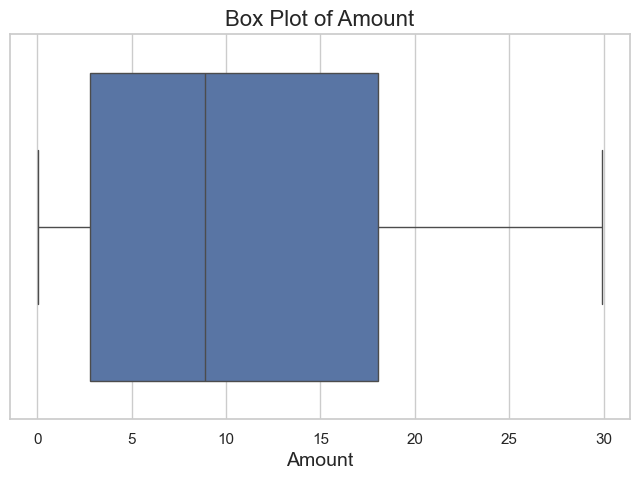

In [366]:
# Box Plot of  'amount' column after winsorizing

# Set the aesthetic style
sns.set(style='whitegrid')

# Create a box plot for 'age'
plt.figure(figsize = (8, 5))
sns.boxplot(x = df['amount'])

# Titles and labels
plt.title('Box Plot of Amount', fontsize=16)
plt.xlabel('Amount', fontsize = 14)

# Show the plot
plt.show()

This updated box plot for amount confirms that the extreme outliers have been effectively capped. The maximum values are now limited, with the whisker extending only up to around 20–25, aligning with the 95th percentile threshold set. This adjusted distribution should improve the model’s ability to interpret the amount feature without being skewed by extreme values.

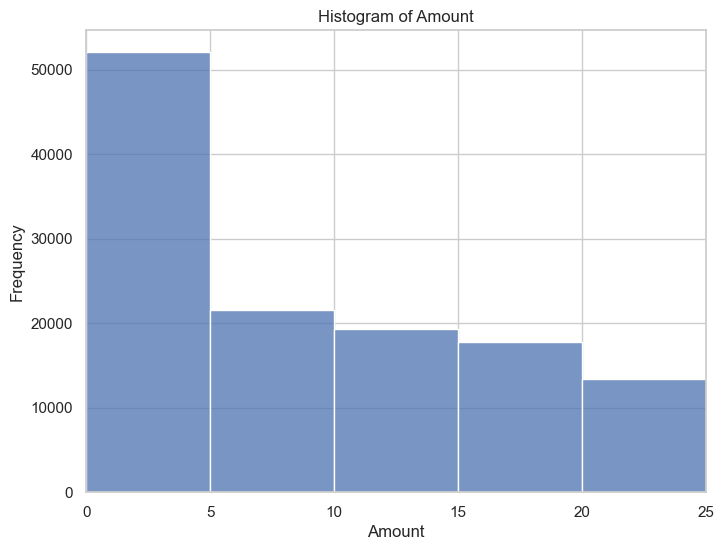

In [367]:
# Specify custom bin edges with the last bin being 30 and above
bin_edges = [0, 5, 10, 15, 20, 25]

# Plot histogram with custom bins and limited x-axis
plt.figure(figsize=(8, 6))
sns.histplot(df['amount'].dropna(), bins=bin_edges)
plt.title("Histogram of Amount")
plt.xlabel("Amount")
plt.ylabel("Frequency")
plt.xlim(0, 25)  # Limit x-axis to focus on range up to 25
plt.show()

The histogram of the "Amount" column, with bins set up to 30, reveals that the majority of transactions fall within the lower range, specifically between 0 and 5. This indicates that lower transaction amounts are far more common, while larger amounts become progressively less frequent within this capped range.

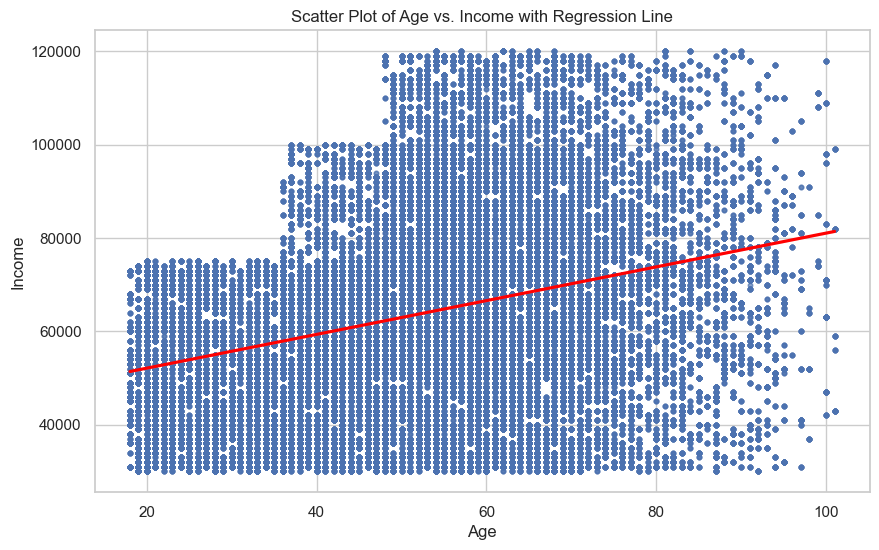

In [368]:
# Scatter plot with a regression line
plt.figure(figsize=(10, 6))
sns.regplot(data=df, x='age', y='income', scatter_kws={'s':10, 'alpha':0.3}, line_kws={'color': 'red'})
plt.title("Scatter Plot of Age vs. Income with Regression Line")
plt.xlabel("Age")
plt.ylabel("Income")
plt.show()

The scatter plot with the regression line shows a positive relationship between age and income, indicating that as age increases, income generally trends higher. However, the spread of data points around the line suggests a substantial variability, meaning age alone is not a strong predictor of income.

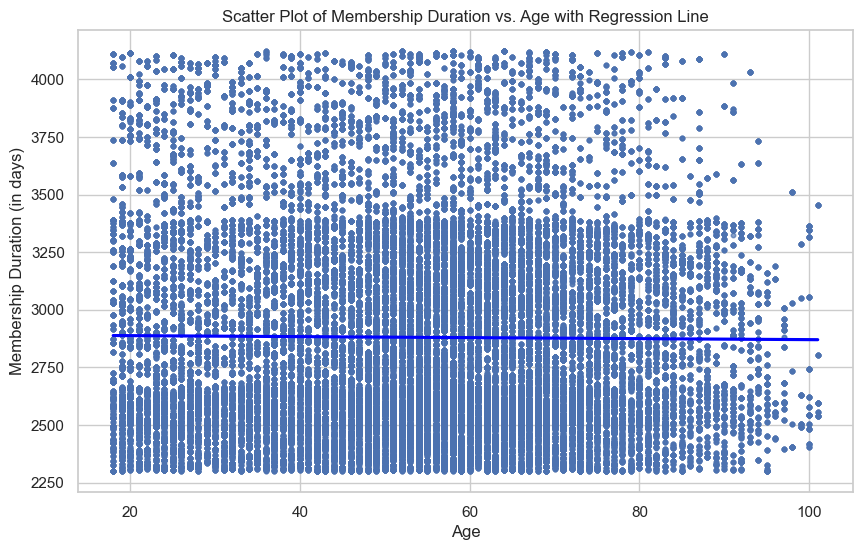

In [369]:
# Scatter plot of Membership Duration vs. Age with regression line
plt.figure(figsize=(10, 6))
sns.regplot(data=df, x='age', y='membership_duration', scatter_kws={'s':10, 'alpha':0.3}, line_kws={'color': 'blue'})
plt.title("Scatter Plot of Membership Duration vs. Age with Regression Line")
plt.xlabel("Age")
plt.ylabel("Membership Duration (in days)")
plt.show()


The scatter plot of membership duration versus age, with a regression line, reveals a largely horizontal trend, suggesting that age does not significantly influence the duration of membership. The data points are widely spread, with no apparent increase or decrease in membership duration as age changes, indicating a consistent membership duration across different age groups.

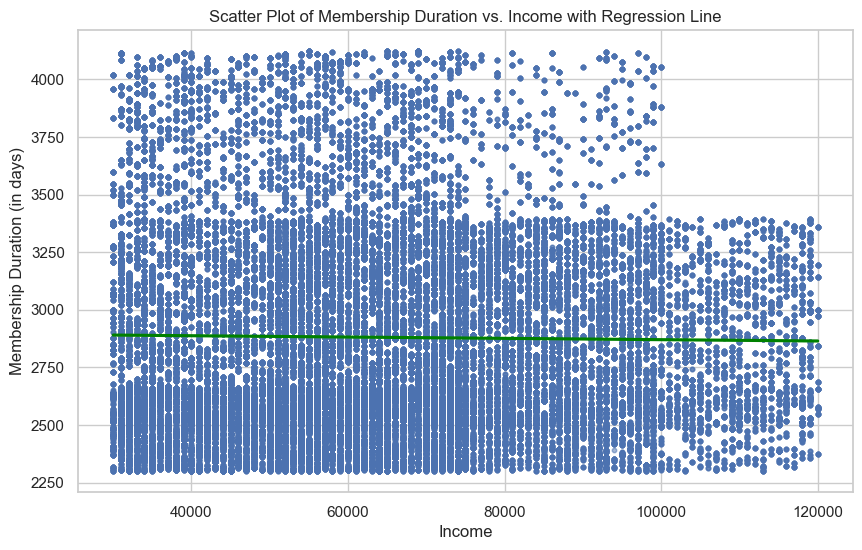

In [370]:
# Scatter plot of Membership Duration vs. Income with regression line
plt.figure(figsize=(10, 6))
sns.regplot(data=df, x='income', y='membership_duration', scatter_kws={'s':10, 'alpha':0.3}, line_kws={'color': 'green'})
plt.title("Scatter Plot of Membership Duration vs. Income with Regression Line")
plt.xlabel("Income")
plt.ylabel("Membership Duration (in days)")
plt.show()


This scatter plot visualizes the relationship between `Income` and `Membership Duration` (in days), with a regression line indicating the general trend. The flat regression line suggests little to no correlation between income levels and the length of membership duration, indicating that membership longevity does not significantly vary with income in this dataset.

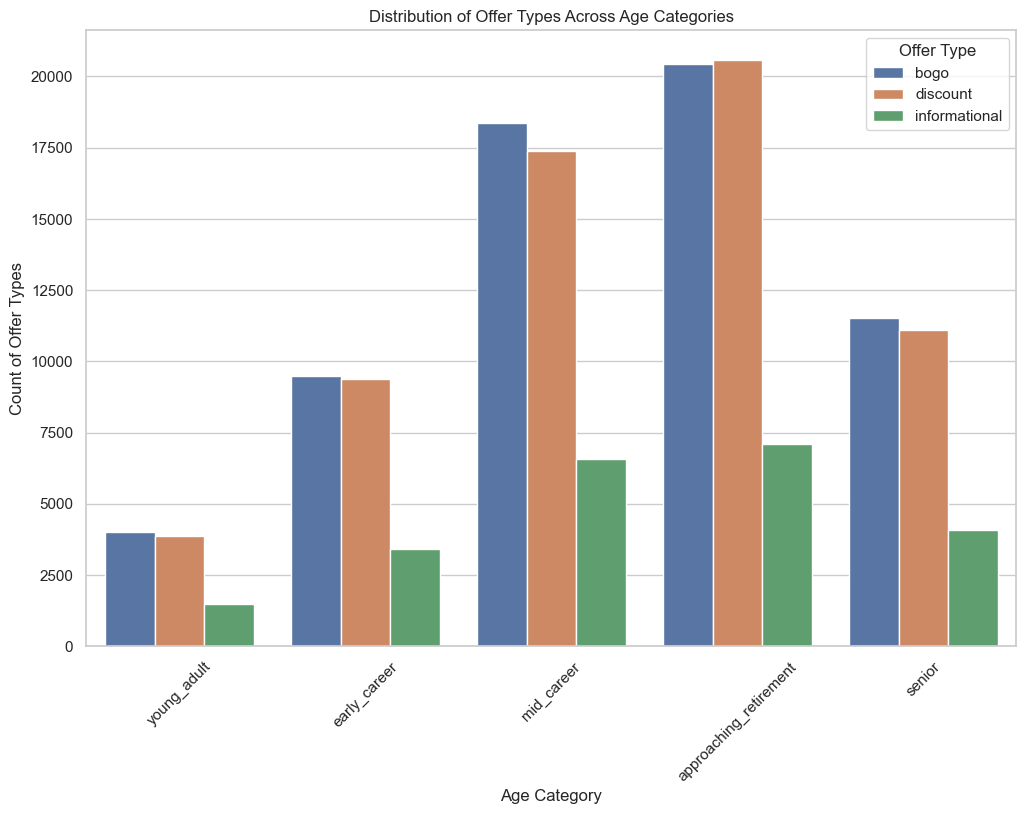

In [371]:
# Set up the bar plot to compare offer_type across different age_cat categories
plt.figure(figsize=(12, 8))
sns.countplot(data=df, x='age_cat', hue='offer_type', palette='deep')
plt.title("Distribution of Offer Types Across Age Categories")
plt.xlabel("Age Category")
plt.ylabel("Count of Offer Types")
plt.legend(title="Offer Type")
plt.xticks(rotation=45)
plt.show()


The bar plot shows the distribution of offer types across different age categories. The "bogo" and "discount" offers are popular across all age categories, with a noticeably higher count in the "mid-career" and "approaching retirement" groups. "Informational" offers are less frequent but still present across all age categories, particularly in the "mid-career" and "approaching retirement" segments. This suggests that "bogo" and "discount" offers may have broad appeal across various life stages, while informational offers are used more selectively.

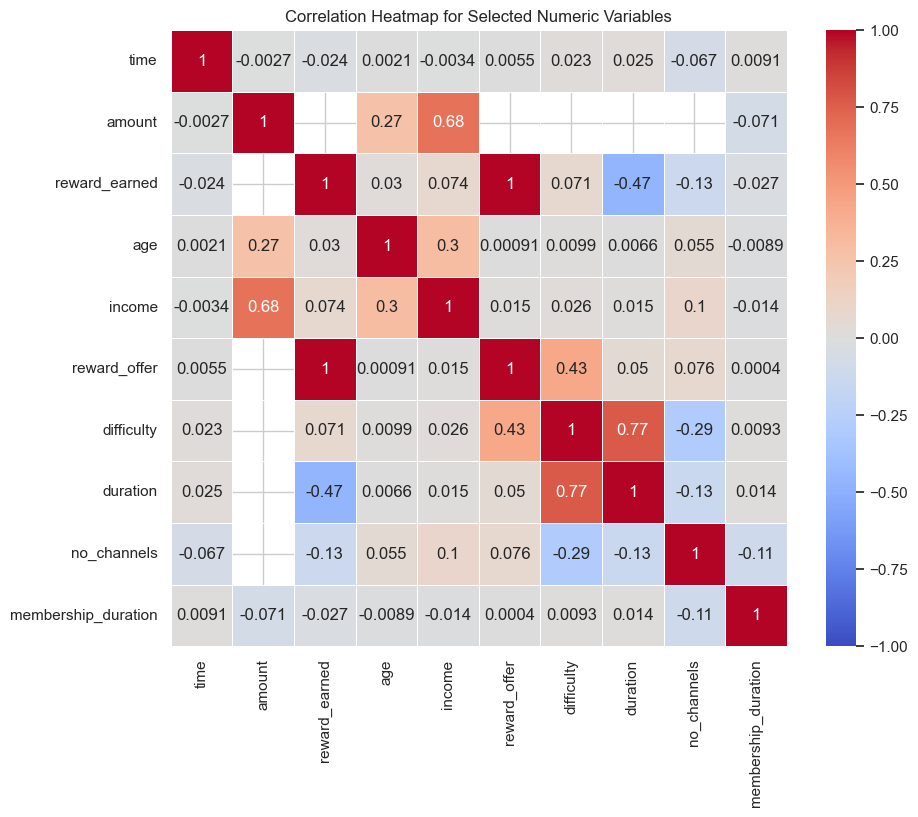

In [372]:
# Select only numeric columns
numeric_columns = ['time', 'amount', 'reward_earned', 'age', 'income', 'reward_offer', 'difficulty', 'duration', 'no_channels', 'membership_duration']

# Calculate the correlation matrix for the selected numeric columns
correlation_matrix = df[numeric_columns].corr()

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Create a heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', square=True, linewidths=0.5, vmin=-1, vmax=1)

# Add title
plt.title('Correlation Heatmap for Selected Numeric Variables')
plt.show()



It looks like you have a detailed correlation heatmap showcasing the relationships between various numeric variables in your dataset. The heatmap is helpful in identifying significant positive and negative correlations. For instance, variables like `difficulty` and `duration` show a relatively strong positive correlation (0.77), while `reward_earned` and `duration` have a moderate negative correlation (-0.47). This visualization is valuable for spotting trends and determining which variables might be impactful for further analysis or modeling.

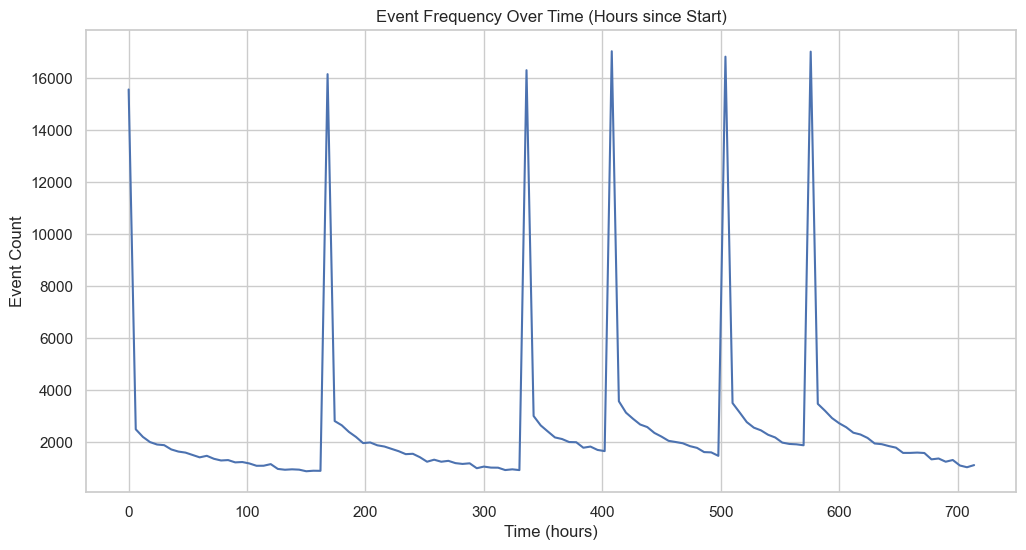

In [373]:
# Group data by 'time' (in hours) and count occurrences
time_counts = df.groupby('time').size()

# Plot event frequency over time
plt.figure(figsize=(12, 6))
time_counts.plot(kind='line')
plt.title("Event Frequency Over Time (Hours since Start)")
plt.xlabel("Time (hours)")
plt.ylabel("Event Count")
plt.show()



The line plot illustrates event frequency over time, with peaks observed at regular intervals, indicating periodic spikes in event occurrences. This pattern suggests a cyclical trend, possibly tied to a specific time-based trigger or user behavior pattern that leads to increased activity at consistent intervals. Analyzing these intervals further could provide insights into user engagement patterns or operational processes influencing event counts. 

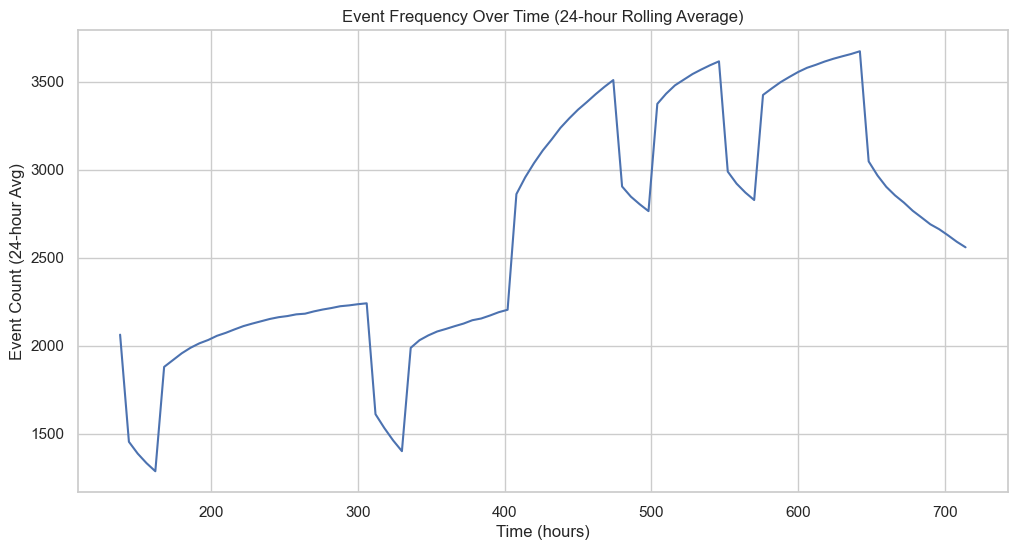

In [374]:
plt.figure(figsize=(12, 6))
time_counts.rolling(window=24).mean().plot(kind='line')  # 24-hour rolling average
plt.title("Event Frequency Over Time (24-hour Rolling Average)")
plt.xlabel("Time (hours)")
plt.ylabel("Event Count (24-hour Avg)")
plt.show()

The 24-hour rolling average plot of event frequency smooths out the fluctuations observed in the previous line plot, providing a clearer view of underlying trends. Peaks and troughs remain visible, indicating recurring cycles, but with a smoother transition. This approach helps to emphasize general patterns in activity over a daily cycle, making it easier to observe consistent peaks and declines in event counts. 

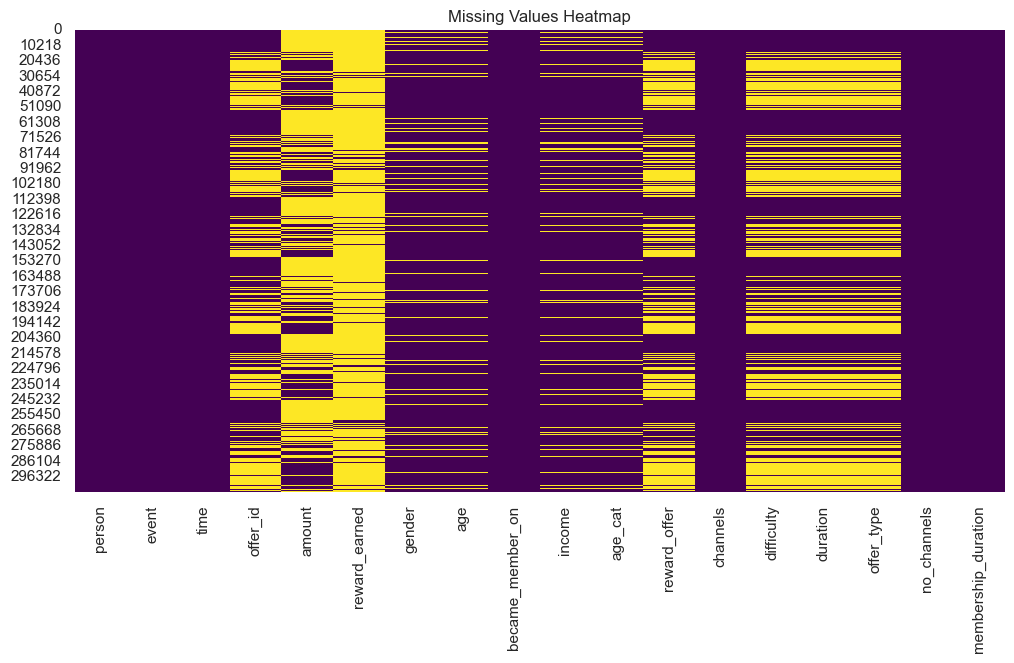

In [375]:
# Visualize missing values as a heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title("Missing Values Heatmap")
plt.show()


The heatmap of missing values reveals patterns of data gaps across columns in the dataset. Yellow stripes indicate missing values, while purple areas show completeness. Certain columns, like `offer_id` and `reward_earned`, have a high concentration of missing data, which could influence analysis and modeling. Addressing these missing values is essential to ensure robust insights from the dataset. 

In [376]:
df['offer_type'].value_counts()
#df['offer_type'].isnull().sum()


offer_type
bogo             71617
discount         69898
informational    26066
Name: count, dtype: int64

The `offer_type` column shows the distribution of different types of offers in the dataset: 

- BOGO: 71,617 instances
- Discount: 69,898 instances
- Informational: 26,066 instances 

This breakdown provides insights into the types of promotions customers received, which may impact further analysis of customer responses and behavior related to each offer type. 

In [377]:
# Dataset for users who completed offers and earned rewards
completed_offers = df[df['reward_earned'].notnull()]

# Dataset for users who received offers but did not complete them
incomplete_offers = df[df['reward_earned'].isnull()]

# Check the sizes of the two datasets
print("Completed Offers:", completed_offers.shape)
print("Incomplete Offers:", incomplete_offers.shape)

# Preview the datasets
completed_offers.head()
incomplete_offers.head()

print(completed_offers.shape)
print(incomplete_offers.shape)

Completed Offers: (33579, 18)
Incomplete Offers: (272955, 18)
(33579, 18)
(272955, 18)


The data has been split into two subsets:

1. Completed Offers: 33,579 entries, representing users who completed offers and earned rewards.
2. Incomplete Offers: 272,955 entries, representing users who received offers but did not complete them.

This segmentation allows for a focused analysis on the factors influencing offer completion and the characteristics of users who completed or did not complete offers. 

In [378]:
# Create a column for each channel type
df['web'] = df['channels'].apply(lambda x: 1 if 'web' in x else 0)
df['email'] = df['channels'].apply(lambda x: 1 if 'email' in x else 0)
df['mobile'] = df['channels'].apply(lambda x: 1 if 'mobile' in x else 0)
df['social'] = df['channels'].apply(lambda x: 1 if 'social' in x else 0)


The code successfully creates individual binary columns (`web`, `email`, `mobile`, and `social`) for each channel type based on the `channels` column in the dataset. A value of 1 indicates the presence of that channel type for a specific offer, while a 0 indicates its absence. This allows for easier analysis of how each channel influences offer engagement and completion. Let me know if you need further insights or adjustments based on these new columns.

In [379]:

# Create a binary target column where 'offer completed' is 1 and other events are 0
df['offer_completed'] = df['event'].apply(lambda x: 1 if x == 'offer completed' else 0)

df['offer_completed'].describe()

count    306534.000000
mean          0.109544
std           0.312321
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: offer_completed, dtype: float64

The code snippet creates a new binary column, `offer_completed`, where rows with the event type `offer completed` are marked as 1, while all other events are marked as 0. The `describe` output shows that only about 10.95% of the entries in the dataset have a completed offer (mean of 0.109544), providing a quick insight into the proportion of completed offers compared to other events. This column will be useful as a target variable for predictive modeling related to offer completion.

# Missing Values

In [380]:
# Special category for Unknowns in 'gender' column
df['gender'] = df['gender'].fillna('Unknown')
df['gender'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 306534 entries, 0 to 306533
Series name: gender
Non-Null Count   Dtype 
--------------   ----- 
306534 non-null  object
dtypes: object(1)
memory usage: 2.3+ MB


The code fills missing values in the `gender` column with a special category labeled "Unknown," ensuring that the column has no null values. The `info()` output confirms this transformation, showing that all 306,534 entries in the `gender` column are now non-null. This approach keeps the data integrity by assigning a distinct value to previously missing entries, which could be valuable in analyses that consider the influence of gender.

In [381]:
# Filling missing values in the `amount` and `reward_earned` columns with 0 
df['amount'] = df['amount'].fillna(0)
df['reward_earned'] = df['reward_earned'].fillna(0)

Filling missing values in the `amount` and `reward_earned` columns with 0 is a practical approach for handling cases where no transaction or reward was recorded. This method assumes that missing entries in these columns represent instances where no monetary transaction took place or no reward was earned, rather than errors in data collection. By setting these missing values to 0, we can retain all records for analysis without introducing artificial averages or medians that could skew results. Additionally, this approach simplifies further processing and modeling, ensuring that these records are appropriately categorized as non-transactional or non-rewarding events.

In [382]:
# Filling missing values in the `reward_offer', 'difficulty', and `duration` columns with 0 
df['reward_offer'] = df['reward_offer'].fillna(0)
df['difficulty'] = df['difficulty'].fillna(0)
df['duration'] = df['duration'].fillna(0)

Filling missing values in the `reward_offer`, `duration`, and `difficulty` columns with 0 is an effective approach for handling cases where no specific reward, time duration, or difficulty level was recorded. This method assumes that missing entries in these columns represent situations where these aspects of an offer were not applicable or where no reward or difficulty level was assigned, rather than errors in data collection. By setting these missing values to 0, we ensure consistency across records and avoid introducing arbitrary averages or medians that could distort the analysis. This approach also simplifies data processing, allowing these records to be treated as baseline or inactive offers where no reward, time, or difficulty was involved.

In [383]:
# Special category 'unknown' for missing values in the 'offr_id' and 'offer_type' columns
df['offer_id'] = df['offer_id'].fillna('Unknown')

df['offer_type'] = df['offer_type'].fillna('Unknown')


The code fills missing values in the `offer_id` and `offer_type` columns with the placeholder string "Unknown." This method is used to indicate that the information for these fields is unavailable, allowing for a clear differentiation between known values and missing data. This approach helps maintain categorical integrity in the dataset, avoiding issues that could arise from null entries during analysis or modeling.

## Imputed datasets

In [384]:
# Imputing 'age' column with the median value in the corresponding 'age_cat' column

imputed_df = df.copy()

# Create flag columns to indicate imputation
imputed_df['age_imputed'] = imputed_df['age'].isna().astype(int)       # 1 if age was imputed, 0 otherwise

# Impute 'age' using the overall median
imputer = SimpleImputer(missing_values=np.nan, strategy = 'median')
imputer.fit(imputed_df[['age']])
imputed_df['age'] = imputer.transform(imputed_df[['age']])
#overall_median_age = imputed_df['age'].median()
#imputed_df['age'] = imputed_df['age'].fillna(overall_median_age)

# Recreate the 'age_cat' column based on the imputed 'age'
bins = [17, 25, 40, 55, 70, float('inf')]
labels = ['young_adult', 'early_career', 'mid_career', 'approaching_retirement', 'senior']
imputed_df['age_cat'] = pd.cut(imputed_df['age'], bins=bins, labels=labels, right=True)

print(imputed_df[['age', 'age_cat']].head())


    age                 age_cat
0  75.0                  senior
1  55.0              mid_career
2  68.0  approaching_retirement
3  55.0              mid_career
4  55.0              mid_career


The code snippet performs several tasks on the `age` column:

1. Imputation: It creates a copy of the DataFrame (`imputed_df`) and then imputes missing values in the `age` column using the median age of the entire dataset.
2. Flag Column: An `age_imputed` flag column is created to indicate whether each value in `age` was imputed (1 if imputed, 0 otherwise).
3. Age Category Recreation: Based on the imputed `age` values, the `age_cat` column is recreated by categorizing ages into different life stages using defined bins and labels.

This approach ensures continuity in age-related data while preserving a record of where imputations were made.

## Dataset without missing values

In [385]:
# Create a dataset with no missing value
df_nonull = df.dropna(subset=['age', 'income', 'age_cat'])


The code snippet creates a new dataset, `df_nonull`, by dropping rows with any missing values in the specified columns: `age`, `income`, and `age_cat`. This ensures that the resulting dataset contains no missing data in these columns, which can be beneficial for analyses that require complete data for these specific variables.

In [386]:
df_nonull.head()

,person,event,time,offer_id,amount,reward_earned,gender,age,became_member_on,income,...,difficulty,duration,offer_type,no_channels,membership_duration,web,email,mobile,social,offer_completed
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,0.0,F,75.0,2017-05-09,100000.0,...,5.0,7.0,bogo,3,2742,1,1,1,0,0
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,0.0,0.0,M,68.0,2018-04-26,70000.0,...,10.0,7.0,discount,3,2390,1,1,1,0,0
5,389bc3fa690240e798340f5a15918d5c,offer received,0,f19421c1d4aa40978ebb69ca19b0e20d,0.0,0.0,M,65.0,2018-02-09,53000.0,...,5.0,5.0,bogo,4,2466,1,1,1,1,0
7,2eeac8d8feae4a8cad5a6af0499a211d,offer received,0,3f207df678b143eea3cee63160fa8bed,0.0,0.0,M,58.0,2017-11-11,51000.0,...,0.0,4.0,informational,3,2556,1,1,1,0,0
8,aa4862eba776480b8bb9c68455b8c2e1,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.0,0.0,F,61.0,2017-09-11,57000.0,...,20.0,10.0,discount,2,2617,1,1,0,0,0


### Rearranging the order of columns 

In [387]:
# List of columns to move to the end
cols_to_move = ['income', 'time', 'age', 'reward_offer', 'difficulty', 'duration', 'no_channels', 'membership_duration']

# Create a new list of columns with the specified ones at the end
new_column_order = [col for col in df.columns if col not in cols_to_move] + cols_to_move

# Reorder the DataFrame columns
df_nonull = df_nonull[new_column_order]

# Display the updated DataFrame
print(df_nonull.head())


                             person           event  \
0  78afa995795e4d85b5d9ceeca43f5fef  offer received   
2  e2127556f4f64592b11af22de27a7932  offer received   
5  389bc3fa690240e798340f5a15918d5c  offer received   
7  2eeac8d8feae4a8cad5a6af0499a211d  offer received   
8  aa4862eba776480b8bb9c68455b8c2e1  offer received   

                           offer_id  amount  reward_earned gender  \
0  9b98b8c7a33c4b65b9aebfe6a799e6d9     0.0            0.0      F   
2  2906b810c7d4411798c6938adc9daaa5     0.0            0.0      M   
5  f19421c1d4aa40978ebb69ca19b0e20d     0.0            0.0      M   
7  3f207df678b143eea3cee63160fa8bed     0.0            0.0      M   
8  0b1e1539f2cc45b7b9fa7c272da2e1d7     0.0            0.0      F   

  became_member_on                 age_cat                      channels  \
0       2017-05-09                  senior          [web, email, mobile]   
2       2018-04-26  approaching_retirement          [web, email, mobile]   
5       2018-02-09  approa

The code snippet rearranges the columns in the `df_nonull` DataFrame, placing specific columns (`income`, `time`, `age`, `reward_offer`, `difficulty`, `duration`, `no_channels`, `membership_duration`) at the end of the DataFrame. This reordering ensures that these columns are positioned last, which can be helpful for analysis or preprocessing steps that need specific columns grouped together or positioned for easy access. 

In [410]:
df_nonull.columns

Index(['person', 'event', 'offer_id', 'amount', 'reward_earned', 'gender',
       'became_member_on', 'age_cat', 'channels', 'offer_type', 'web', 'email',
       'mobile', 'social', 'offer_completed', 'income', 'time', 'age',
       'reward_offer', 'difficulty', 'duration', 'no_channels',
       'membership_duration'],
      dtype='object')

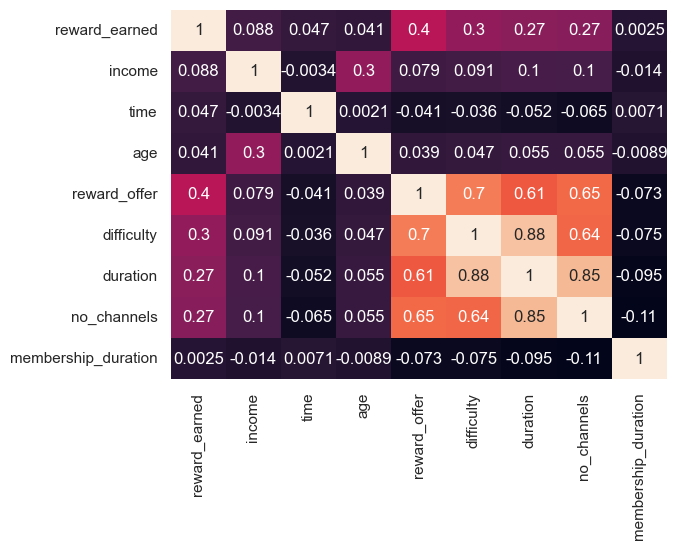

In [414]:
corrcolumns = ['reward_earned', 'income', 'time', 'age',
       'reward_offer', 'difficulty', 'duration', 'no_channels',
       'membership_duration']
sns.heatmap(df_nonull.loc[:, corrcolumns].corr(),annot= True, cbar = False)
plt.savefig('sns_heatmap1.png')

The heatmap illustrates the correlation between key continuous features in the dataset. We observe a strong positive correlation between `difficulty`, `duration`, and `no_channels`, suggesting that more challenging offers are associated with longer durations and more channels. Additionally, `reward_offer` shows a moderate correlation with `difficulty`, `duration`, and `no_channels`, indicating that these features may collectively influence the reward structure of the offers. The other variables show low or negligible correlations with each other, implying relatively independent relationships.

# Comparative Model Analysis for Offer Responsiveness (Nonull dataset)

### Creating the np.array for independent and dependent variables

In [388]:
# Feautures (independent variables) 
X = df_nonull.drop(['person', 'event', 'offer_id', 'amount', 'reward_earned', 'became_member_on', 'channels', 'offer_completed'], axis=1)

# Target (dependent) variable array
y = df_nonull.loc[:, 'offer_completed'].values


The code snippet creates `X`, the feature matrix, by dropping non-relevant and identifier columns from `df_nonull`, and `y`, the target variable, using the `offer_completed` column. This prepares the data for model training with relevant predictors and the outcome to be predicted.

### OneHotEncoding the categorical variables

In [391]:
ct = ColumnTransformer(transformers = [('encoder', OneHotEncoder(), ['gender', 'age_cat', 'offer_type'])], remainder = 'passthrough')

X = ct.fit_transform(X)


The code snippet uses `ColumnTransformer` with `OneHotEncoder` to encode the categorical variables `gender`, `age_cat`, and `offer_type` in the feature matrix `X`, while keeping the remaining columns unchanged (`remainder='passthrough'`). This transforms `X` into a format suitable for model training with one-hot encoded categorical variables alongside the continuous variables.

## Splitting the dataset into the Training and Test set

In [392]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 123)

In [394]:
print(y_test)

[0 0 0 ... 0 0 0]


The code snippet splits the dataset into training and test sets using `train_test_split`, with 80% of the data allocated for training (`X_train`, `y_train`) and 20% for testing (`X_test`, `y_test`). The `random_state=123` ensures reproducibility by setting a seed for the random number generator.

## Feauture Scaling

In [395]:
# Standardizing 'income', 'time', 'age', 'reward_offer', 'difficulty', 'duration', 'no_channels', 'membership_duration' columns
sc = StandardScaler()
X_train = sc.fit_transform(X_train[:, -8:])
X_test = sc.fit_transform(X_test[:, -8:])

The code snippet applies feature scaling using `StandardScaler()` to standardize numerical columns (`income`, `time`, `age`, `reward_offer`, `difficulty`, `duration`, `no_channels`, `membership_duration`) in the training (`X_train`) and test sets (`X_test`). This ensures these features have a mean of 0 and a standard deviation of 1, improving model performance by normalizing the data.

## Logistic Regression

In [396]:
lc = LogisticRegression(solver='saga', max_iter=500, random_state = 123)
lc.fit(X_train, y_train)


LogisticRegression(max_iter=500, random_state=123, solver='saga')

In [397]:
y_pred = lc.predict(X_test)
print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1))

[[1 0]
 [0 0]
 [0 0]
 ...
 [0 0]
 [0 0]
 [0 0]]


### Confusion matrix, accuracy score, precision, recall, F1 score

In [406]:
# Calculate confusion matrix 
cm = confusion_matrix(y_test, y_pred)
print(cm)

# Calculate accuracy_score
accuracy_score = accuracy_score(y_test, y_pred)

# Calculate precision
precision = precision_score(y_test, y_pred)

# Calculate recall
recall = recall_score(y_test, y_pred)

# Calculate F1-score
f1 = f1_score(y_test, y_pred)

# Print the scores
print("Accuracy score:", accuracy_score)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

[[47741   340]
 [ 6260   212]]
Accuracy score: 0.8790167360181842
Precision: 0.38405797101449274
Recall: 0.032756489493201486
F1-score: 0.06036446469248292


### GridSearch with parameters

In [415]:

# Define the parameter grid for GridSearchCV
param_grid = [
    {'solver': ['liblinear'], 'penalty': ['l1', 'l2'], 'C': [0.01, 0.1, 1, 10, 100], 'max_iter': [500, 1000], 'class_weight': [None, 'balanced']},
    {'solver': ['lbfgs'], 'penalty': ['l2'], 'C': [0.01, 0.1, 1, 10, 100], 'max_iter': [500, 1000], 'class_weight': [None, 'balanced']},
    {'solver': ['saga'], 'penalty': ['l1', 'l2', 'elasticnet'], 'C': [0.01, 0.1, 1, 10, 100], 'max_iter': [500, 1000], 'class_weight': [None, 'balanced'], 'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]}
]


# Initialize the logistic regression model
lr = LogisticRegression(random_state=123)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=lr, param_grid=param_grid, 
                           scoring='f1', cv=5, verbose=3, n_jobs=-1)

# Fit the model to the training data
grid_search.fit(X_train, y_train)

# Print the best parameters and the best F1 score
print("Best Parameters:", grid_search.best_params_)
print("Best F1 Score:", grid_search.best_score_)

# Predict using the best estimator
y_pred = grid_search.best_estimator_.predict(X_test)

# Evaluate the model's performance
print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 360 candidates, totalling 1800 fits


c:\Users\cerde\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best Parameters: {'C': 0.01, 'class_weight': 'balanced', 'max_iter': 500, 'penalty': 'l1', 'solver': 'liblinear'}
Best F1 Score: 0.41217031214191036
              precision    recall  f1-score   support

           0       0.99      0.64      0.78     48081
           1       0.26      0.95      0.41      6472

    accuracy                           0.68     54553
   macro avg       0.63      0.80      0.60     54553
weighted avg       0.90      0.68      0.74     54553



The results indicate that while the model has achieved a high precision (0.99) for the majority class, its recall for this class is relatively lower (0.64), suggesting it is not capturing all instances effectively. For the minority class, the recall is high (0.95), meaning the model correctly identifies a large portion of the minority class, though precision remains low at 0.26. The overall accuracy is 0.68, and the best F1 score achieved for the model, balancing precision and recall, is 0.412, reflecting the trade-off between identifying both classes accurately under the class imbalance.

## Random Forest Model

In [417]:
# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],        # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],        # Maximum depth of each tree
    'min_samples_split': [2, 5, 10],        # Minimum number of samples required to split a node
    'min_samples_leaf': [1, 2, 4],          # Minimum number of samples required at each leaf node
    'max_features': ['sqrt', 'log2'],       # Number of features to consider for the best split
    'class_weight': [None, 'balanced']      # Address class imbalance
}

# Initialize the Random Forest classifier
rf = RandomForestClassifier(random_state=123)

# Initialize GridSearchCV
grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid, 
                              scoring='f1', cv=5, verbose=3, n_jobs=-1)

# Fit the model to the training data
grid_search_rf.fit(X_train, y_train)

# Print the best parameters and the best F1 score
print("Best Parameters:", grid_search_rf.best_params_)
print("Best F1 Score:", grid_search_rf.best_score_)

# Predict using the best estimator
y_pred_rf = grid_search_rf.best_estimator_.predict(X_test)

# Evaluate the model's performance
print("Accuracy Score:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))


Fitting 5 folds for each of 432 candidates, totalling 2160 fits
Best Parameters: {'class_weight': 'balanced', 'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 300}
Best F1 Score: 0.5988330444731026
Accuracy Score: 0.8805015306215973
              precision    recall  f1-score   support

           0       0.97      0.90      0.93     48081
           1       0.50      0.76      0.60      6472

    accuracy                           0.88     54553
   macro avg       0.73      0.83      0.77     54553
weighted avg       0.91      0.88      0.89     54553



## Gradient Boosting